In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import NamedTuple, Union

from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

/var/folders/0j/j0zxpm794vv_vrttpm9nbw_m0000gn/T/ipykernel_98788/1861155039.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


## Generate Data

network_input =  [x, y]
- x: tuple = $[time, displacement]^{n}$
- y: binary = $y \in \{0,1\}^{n}$

where n is the sample size

In [3]:
seed = 144
np.seed = seed

In [4]:
# def get_random_indexes(num):
#     deck = list(range(num))
#     random.shuffle(deck)

#     return sorted([deck.pop() for _ in range(num)])

# result = NamedTuple("Dataset", (('dataset', tuple), ('classes', tuple)))
# def generate_dataset(num_samples, *, random_state = 144, func = lambda x: np.sin(x), noisy_size = 50, detailed = False) -> Union[tuple, result]:
#     np.seed = random_state
    
#     init_x = np.linspace(0, 2 * np.pi, num_samples)
#     rand_indexes = get_random_indexes(noisy_size)
#     noise = np.random.randint(-1000, 1000, (noisy_size, 1)) / 500

#     counter = 0
#     x_0 = []
#     x_1 = []
#     y = []


#     class_a = []
#     class_a_t = []
#     class_b = []
#     class_b_t = []
#     for i, t in enumerate(init_x):
#         if i in rand_indexes:
#             val = noise[counter][0]
#             counter += 1
#             label = 0
#             class_a.append(val)
#             class_a_t.append(t)
#         else:
#             val = func(t)
#             label = 1
#             class_b.append(val)
#             class_b_t.append(t)

#         x_1.append(val)
#         x_0.append(t)
#         y.append(label)

#     if detailed:
        
#         return result((x_0, x_1, y), ((class_a, class_a_t), (class_b, class_b_t)))
#     else:
#         x = np.array(list(zip(x_0, x_1)))
#         return x,y
    


In [5]:
# plt.scatter(cl_at, cl_a, color="r")
# plt.scatter(cl_bt, cl_b, color="b")
# plt.show()

In [6]:

sample_size = 100
f = lambda x: np.sin(x)


# ni = zip(rand_indexes, noise)
init_x = np.linspace(0, 2 * np.pi, sample_size)

deck = list(range(100))
random.shuffle(deck)

rand_indexes = []
for _ in range(50):
    rand_indexes.append(deck.pop())

rand_indexes.sort()
noise = np.random.randint(-1000, 1000, (50, 1)) / 1000

counter = 0
x_0 = []
x_1 = []
y = []


class_a = []
class_a_t = []
class_b = []
class_b_t = []
for i, t in enumerate(init_x):
    if i in rand_indexes:
        val = noise[counter][0]
        counter += 1
        label = 0
        class_a.append(val)
        class_a_t.append(t)
    else:
       val = f(t)
       label = 1
       class_b.append(val)
       class_b_t.append(t)

    x_1.append(val)
    x_0.append(t)
    y.append(label)
    


In [7]:
x = np.array(list(zip(x_0, x_1)))
y = np.array(y)

In [8]:
y

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

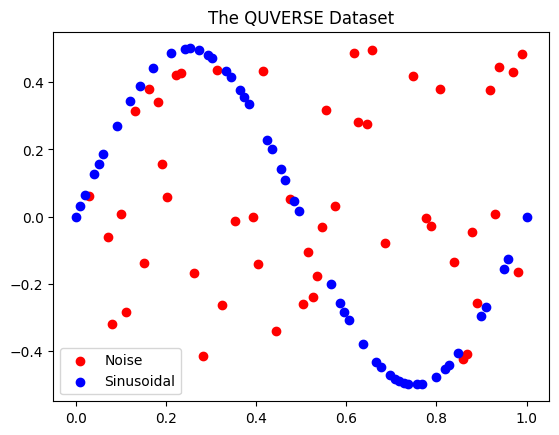

In [34]:
# Normalizatin
x[:,0] = x[:,0] / (np.max(x[:,0]) - np.min(x[:,0]))
x[:,1] = x[:,1] / (np.max(x[:,1]) - np.min(x[:,1]))

num_classes = 2
num_features = 2
x_red = x[y==0]
x_blue = x[y==1]

plt.scatter(x_red[:,0], x_red[:,1], c='r', label="Noise")
plt.scatter(x_blue[:,0], x_blue[:,1], c='b', label="Sinusoidal")
plt.title("The QUVERSE Dataset")
plt.legend()

## Split Dataset

In [10]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 80
Test set size:  20


## Data Embedding

### Input

/opt/miniconda3/envs/qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


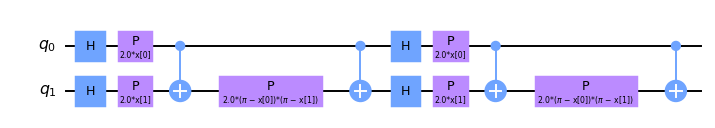

In [11]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

/opt/miniconda3/envs/qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


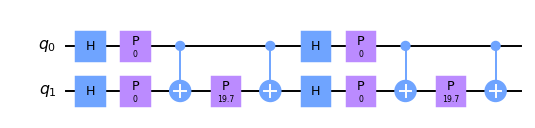

In [12]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}).decompose().draw('mpl', scale=0.7)

### Ansatz

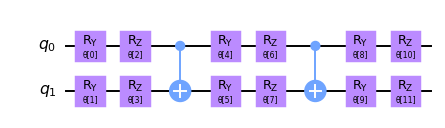

In [13]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

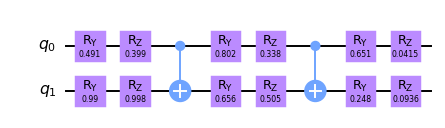

In [14]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

### Compose Circuit

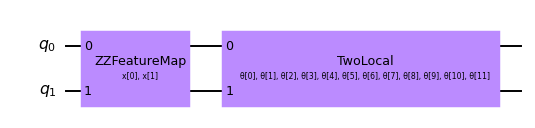

In [15]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

## Define Estimator

In [16]:
options = {}
qasm_sim = AerSimulator()
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

## Define Neural Network

We will be using the `EstimatorQNN`

In [17]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [18]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [19]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

## Train Classifier

In [20]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1 converted to [0 1]
Label 0 converted to [1 0]


In [21]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)

In [79]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train, y_train_1h)

Text(0.5, 1.0, 'Training loss')

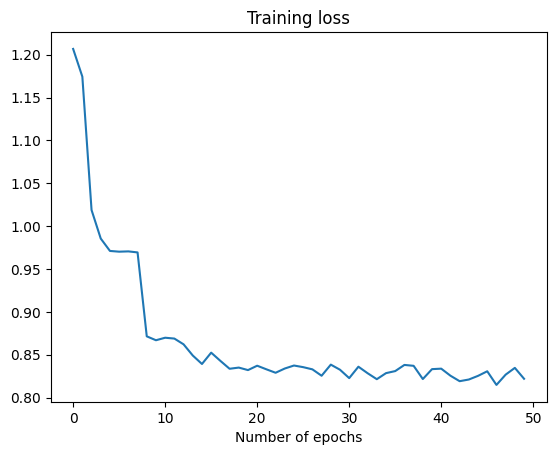

In [80]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [62]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.625
Score on the test set 0.4


In [63]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [64]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [65]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [0, 1], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

x_r = x_all[np.all(y_all == [1, 0], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

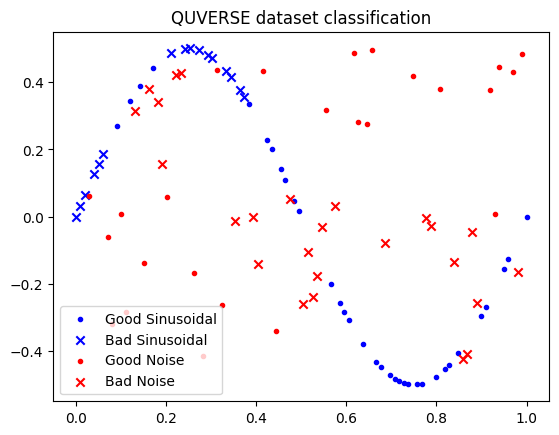

In [66]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good Sinusoidal")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad Sinusoidal")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good Noise")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad Noise")

plt.title("QUVERSE dataset classification")
plt.legend()

In [30]:
from sklearn.metrics import confusion_matrix

In [43]:
y_test_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [31]:
confusion_matrix(y_test_1h, y_test_pred)

ValueError: multilabel-indicator is not supported